 # Anime Popularity Prediction: Model Training

## Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from scipy.stats import kendalltau, spearmanr
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

## Data Preparation

In [2]:
anime_df = pd.read_csv("processed_anime_data.csv")

anime_df = anime_df.sample(frac=1).reset_index(drop=True)
train_size = int(len(anime_df) * 0.8)
train_df = anime_df.iloc[:train_size]
test_df = anime_df.iloc[train_size:]

X_train = train_df.drop(["anime_id", "popularity"], axis=1)
y_train = train_df["popularity"]
X_test = test_df.drop(["anime_id", "popularity"], axis=1)
y_test = test_df["popularity"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Initial Model Training

In [3]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

y_pred = model.predict(dtest)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
spearman, _ = spearmanr(y_test, y_pred)
kendall, _ = kendalltau(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Spearman's rank correlation: {spearman:.2f}")
print(f"Kendall's Tau: {kendall:.2f}")

MAE: 124.90
RMSE: 14.63
Spearman's rank correlation: 1.00
Kendall's Tau: 0.98


## Hyperparameter Tuning

In [4]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1,
)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0}
Best MAE: 98.55908254910727


## Final Model Training and Evaluation

In [5]:
best_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    objective="reg:squarederror",
)
best_model.fit(X_train_scaled, y_train)

y_pred_final = best_model.predict(X_test_scaled)

mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(root_mean_squared_error(y_test, y_pred_final))
spearman_final, _ = spearmanr(y_test, y_pred_final)
kendall_final, _ = kendalltau(y_test, y_pred_final)

print(f"Final MAE: {mae_final:.2f}")
print(f"Final RMSE: {rmse_final:.2f}")
print(f"Final Spearman's rank correlation: {spearman_final:.2f}")
print(f"Final Kendall's Tau: {kendall_final:.2f}")

Final MAE: 58.23
Final RMSE: 10.95
Final Spearman's rank correlation: 1.00
Final Kendall's Tau: 0.99


## Feature Importance Analysis

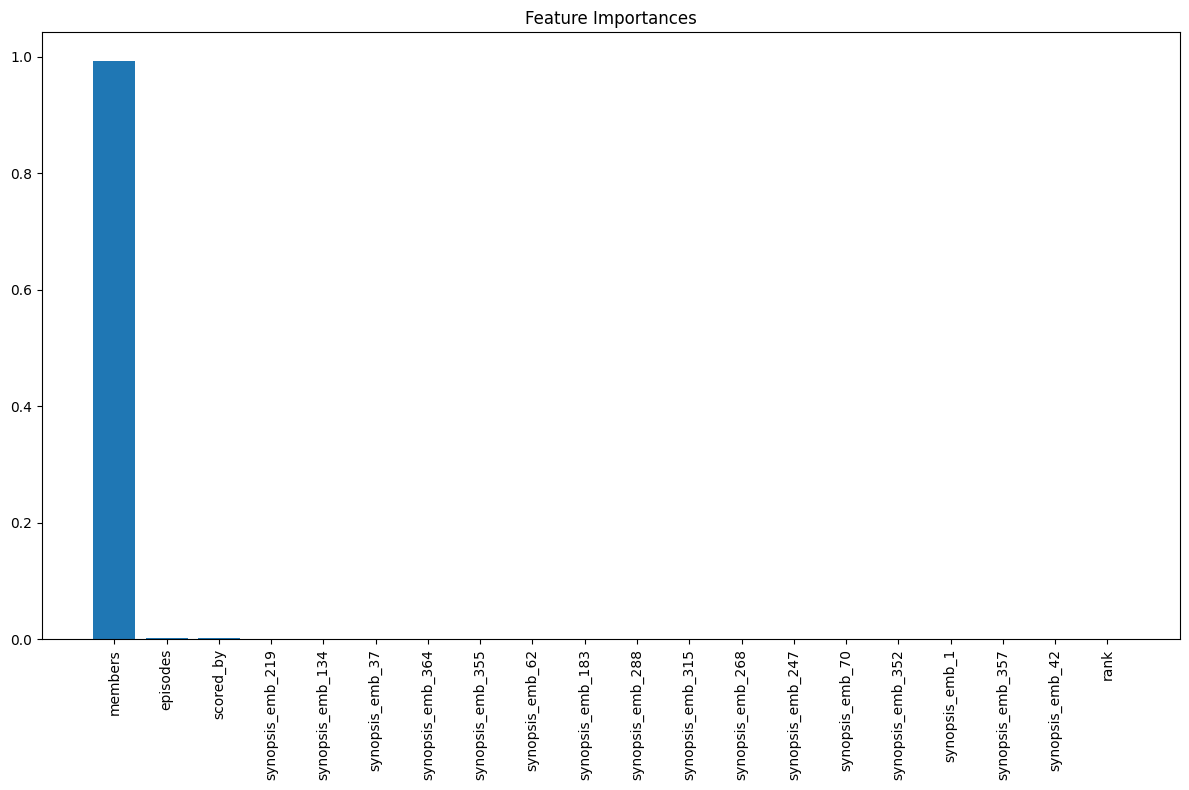

In [6]:
importance = best_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importance)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(20), importance[indices][:20])
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

## Model Interpretation

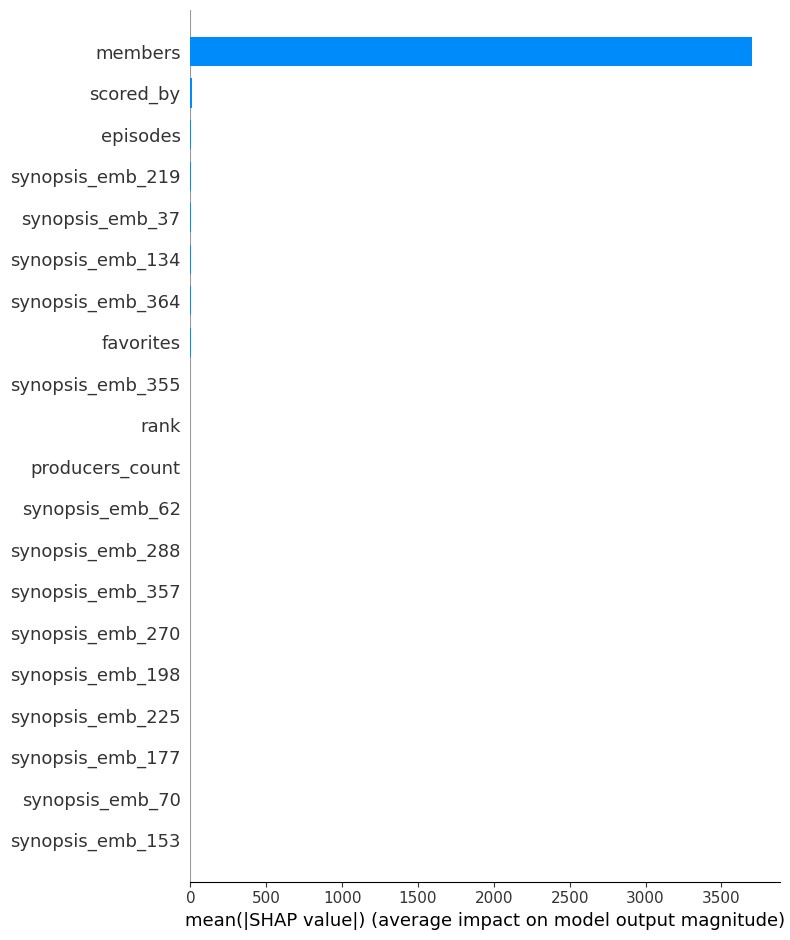

In [7]:
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names)

shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :], feature_names=feature_names)